In [2]:
%pip install geodata-harvester geoviews holoviews hvplot panel jupyter-bokeh

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [3]:
import os
import pandas as pd
import numpy as np
import IPython
import geopandas as gpd

import rasterio
import rioxarray
# Import harvest function from geodata_harvester
from geodata_harvester import harvest, settingshandler
from geodata_harvester.arc2meter import calc_arc2meter

import geoviews as gv
import holoviews as hv
import hvplot.xarray
import panel as pn


In [4]:
# Path to file:
path_settings = 'input-data'
# Filename
fname_settings = 'settings-slga-test.yml'
infname = os.path.join(path_settings,fname_settings)

In [5]:
# print settings as json
settingshandler.display_settings(infname)

# store settings as namespace (easier to interact with)
settings = settingshandler.main(infname)

{
    "colname_lat": "Lat",
    "colname_lng": "Long",
    "date_max": "2023-11-30",
    "date_min": "2023-10-01",
    "infile": "input-data/test-location.csv",
    "outpath": "output-data/",
    "target_bbox": [
        116.26012130269045,
        -29.307384715430175,
        116.3875862387774,
        -29.220237788279107
    ],
    "target_res": 3.0,
    "target_sources": {
        "SLGA": {
            "Bulk_Density": [
                "0-5cm",
                "5-15cm"
            ],
            "Clay": [
                "0-5cm",
                "5-15cm"
            ]
        }
    },
    "time_intervals": 2
}


The harvest.run functions returns a dataframe with filenames of all downloaded data layers. All results and images are saved to disk in the output directory as specified in settings file.

The following main steps are automatically executed within the harvest.run() function:

loading settings from config yaml file
if bounding box is not provided, create bounding box from input file points plus padding of 0.05 deg
downloading data layers for each source as specified in settings file (this may take a while, depending on number of layers, size of region, and speed of internet connection)
processing data layers as specified in settings file (e.g., temporal binning)
save downloaded image files to disk as GeoTiffs (.tif)
save summary table of downloaded files as CSV ( see download_summary.csv)
extract data for point locations provided in input file (Lat and Long columns)
save extracted point result table to disk as CSV (results.csv) and as geopackage (results.gpkg)
preview-check of generated raster maps (for analysis, please use the generated GeoTiffs)

Starting the data harvester -----
ℹ Found the following 1 sources: ['SLGA']


⌛ Downloading SLGA data...
⚑ SLGA_Bulk_Density_0-5cm.tif already exists, skipping download
⚑ SLGA_Bulk_Density_5-15cm.tif already exists, skipping download
⚑ SLGA_Bulk_Density_0-5cm_5percentile.tif already exists, skipping download
⚑ SLGA_Bulk_Density_0-5cm_95percentile.tif already exists, skipping download
⚑ SLGA_Bulk_Density_5-15cm_5percentile.tif already exists, skipping download
⚑ SLGA_Bulk_Density_5-15cm_95percentile.tif already exists, skipping download
⚑ SLGA_Clay_0-5cm.tif already exists, skipping download
⚑ SLGA_Clay_5-15cm.tif already exists, skipping download
⚑ SLGA_Clay_0-5cm_5percentile.tif already exists, skipping download
⚑ SLGA_Clay_0-5cm_95percentile.tif already exists, skipping download
⚑ SLGA_Clay_5-15cm_5percentile.tif already exists, skipping download
⚑ SLGA_Clay_5-15cm_95percentile.tif already exists, skipping download

Extracting data points for test-location.csv  -----
⊙ Extracting val

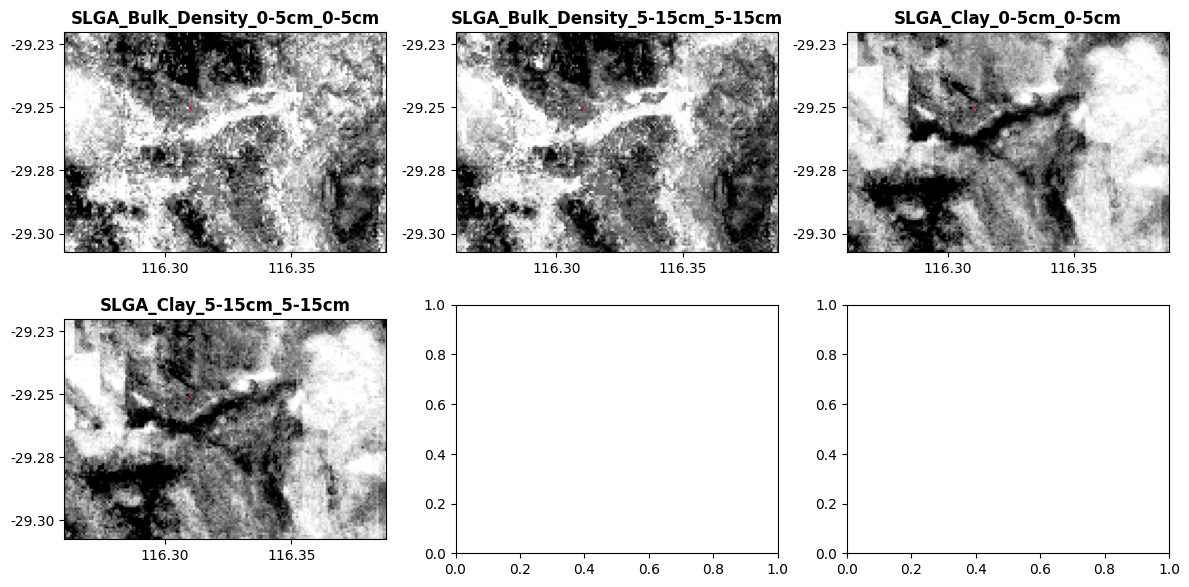


🎉 🎉 🎉 Harvest complete 🎉 🎉 🎉


In [6]:
# run automatic harvest function
df = harvest.run(infname, preview = True, return_df = True)

In [7]:
# Load in the dataset defining our location of interest as a geopandas dataframe
gdfpoints = gpd.read_file(settings.infile)

# Assing the data to well-named variables
lngs = gdfpoints[settings.colname_lng].astype(float)
lats = gdfpoints[settings.colname_lat].astype(float)
coords = np.vstack((lngs, lats)).T

# Check the data looks reasonable
gdfpoints

,Lat,Long,geometry
0,-29.25,116.31,None


In [8]:
# Estimate resolution in meters:
lat_center = (settings.target_bbox[1]+settings.target_bbox[3])/2
xres_meters, yres_meters = calc_arc2meter(settings.target_res, lat_center)
print(f'Info: {settings.target_res} arcsec resolution corresponds to {xres_meters:.1f}m x {yres_meters:.1f}m in x,y direction respectively (at Latitude: {lat_center:.2f}).')

Info: 3.0 arcsec resolution corresponds to 80.9m x 92.6m in x,y direction respectively (at Latitude: -29.26).


In [9]:
tif_path_bulk_density_5 = 'output-data/SLGA_Bulk_Density_0-5cm.tif'
tif_path_bulk_density_15 = 'output-data/SLGA_Bulk_Density_5-15cm.tif'
tif_path_clay_5 = 'output-data/SLGA_Clay_0-5cm.tif'
tif_path_clay_15 = 'output-data/SLGA_Clay_5-15cm.tif'

img_BD_5 = rioxarray.open_rasterio(tif_path_bulk_density_5).rio.reproject('EPSG:3857')
img_BD_15 = rioxarray.open_rasterio(tif_path_bulk_density_15).rio.reproject('EPSG:3857')
img_CL_5 = rioxarray.open_rasterio(tif_path_clay_5).rio.reproject('EPSG:3857')
img_CL_15 = rioxarray.open_rasterio(tif_path_clay_15).rio.reproject('EPSG:3857')

map_tiles = hv.element.tiles.EsriImagery().opts(width=600, height=400)


map_img_BD_5 = hv.Image(img_BD_5, kdims=['x','y']).opts(cmap='viridis', title='SLGA_Bulk_Density_0-5cm',fontscale=1.2, colorbar=True)
map_img_BD_15 = hv.Image(img_BD_15, kdims=['x','y']).opts(cmap='viridis', title='SLGA_Bulk_Density_5-15cm',fontscale=1.2, colorbar=True)
map_img_CL_5 = hv.Image(img_CL_5, kdims=['x','y']).opts(cmap='magma', title='SLGA_Clay_0-5cm',fontscale=1.2, colorbar=True)
map_img_CL_15 = hv.Image(img_CL_15, kdims=['x','y']).opts(cmap='magma', title='SLGA_Clay_5-15cm',fontscale=1.2, colorbar=True)

map_combo_BD_5 = map_tiles * map_img_BD_5
map_combo_BD_15 = map_tiles * map_img_BD_15
map_combo_CL_5 = map_tiles * map_img_CL_5
map_combo_CL_15 = map_tiles * map_img_CL_15

In [10]:
pn.Column(
    pn.Row(map_combo_BD_5, map_combo_BD_15),
    pn.Row(map_combo_CL_5, map_combo_CL_15))

BokehModel(combine_events=True, render_bundle={'docs_json': {'dd86fcb6-7e5c-459f-872f-ed6021ff672d': {'version…